### Load libraries

In [1]:
pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8 MB 23 kB/s 
     |████████████████████████████████| 448 kB 52.5 MB/s 
     |████████████████████████████████| 3.8 MB 56.9 MB/s 
     |████████████████████████████████| 50 kB 8.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=2136bf261d91013de9aeeee4ca3fc7a7f8ac08df85e04b29ce2095449161729a
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [2]:
!pip install -U -q PyDrive
!pip install -U segmentation-models
!pip install opencv-python

In [3]:
pip install 'h5py<3.0.0'

     |████████████████████████████████| 2.9 MB 5.1 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [ ]:
#!pip install -U tensorboard

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

In [5]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.1.0


In [6]:
import scipy.io

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from collections import Counter
from tensorboard.plugins.hparams import api as hp
from tensorflow import feature_column
import os

In [8]:
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `tf.keras` framework.


##Load images from drive

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp ./gdrive/My\ Drive/OCTProject/datasets/UMNCompletonormalpix2pix/UMNDatasetSplited.zip .
!unzip UMNDatasetSplited.zip

In [ ]:
!cp -r ./gdrive/'My Drive'/OCTProject/datasets/DatasetUNAL/dukeImagesFluidROIReshSplited.zip .
!unzip dukeImagesFluidROIReshSplited.zip

In [ ]:
!cp -r ./gdrive/'My Drive'/OCTProject/datasets/DatasetUNAL/dukeImagesFocosROIReshSplited.zip .
!unzip dukeImagesFocosROIReshSplited.zip

In [10]:
!cp ./gdrive/MyDrive/OCTProject/datasets/DatasetUNAL/oftalmoCystDarkImgs.zip  .
!unzip oftalmoCystDarkImgs.zip

Archive:  oftalmoCystDarkImgs.zip
   creating: oftalmoCystDarkImgs/
   creating: oftalmoCystDarkImgs/pix2pixNoClean/
   creating: oftalmoCystDarkImgs/pix2pixNoClean/training/
   creating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/
  inflating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/subject_10_120131130174037OS1EMDO.jpg  
  inflating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/subject_7_920150311073302OD1VO.jpg  
  inflating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/subject_0_1520151223080622OD1VO.jpg  
  inflating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/subject_2_1320150401072349OS1VO.jpg  
  inflating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/subject_6_4520131130174002OS1VO.jpg  
  inflating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/subject_3_3520150925125053OS1VO.jpg  
  inflating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/subject_3_2120141209112723OS1VO.jpg  
  inflating: oftalmoCystDarkImgs/pix2pixNoClean/training/img/subject_

In [ ]:
!cp ./gdrive/MyDrive/OCTProject/datasets/DatasetUNAL/oftalmoFocisDarkImgs.zip  .
!unzip oftalmoFocisDarkImgs.zip

In [ ]:
!cp ./gdrive/MyDrive/OCTProject/datasets/DatasetUNAL/oftalmoFocis.zip  .
!unzip oftalmoFocis.zip

In [ ]:
!cp ./gdrive/MyDrive/OCTProject/datasets/DatasetUNAL/oftalmoFluidsDarkImgs.zip  .
!unzip oftalmoFluidsDarkImgs.zip

In [ ]:
!cp ./gdrive/MyDrive/OCTProject/datasets/DatasetUNAL/oftalmoDrusenDarkImgs.zip  .
!unzip oftalmoDrusenDarkImgs.zip

## Define initial model

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [12]:
def _tensor_shape(tensor):
    return tensor.shape

In [13]:
def squeeze_excite_block(input_tensor, ratio=8):
  """ Create a channel-wise squeeze-excite block
    Args:
        input_tensor: input Keras tensor
        ratio: number of output filters
    Returns: a Keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    """
  init = input_tensor
  channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
  filters = _tensor_shape(init)[channel_axis]
  se_shape = (1, 1, filters)

  se = tf.keras.layers.GlobalAveragePooling2D()(init)
  se = tf.keras.layers.Reshape(se_shape)(se)
  initializer = tf.keras.initializers.Zeros()
  se = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
  se = tf.keras.layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
  #se = tf.keras.layers.Dense(filters // ratio, activation='relu', kernel_initializer=initializer, use_bias=False)(se)
  #se = tf.keras.layers.Dense(filters, activation='sigmoid', kernel_initializer=initializer, use_bias=False)(se)

  if tf.keras.backend.image_data_format() == 'channels_first':
    se = Permute((3, 1, 2))(se)

  x = tf.keras.layers.multiply([init, se])
  
  return x

first training made setting just last layer for duke, umn got same last layer
<br>
taking driu with all squezze to try over duke

In [14]:
def f(layers):
    return tf.keras.backend.concatenate(layers, axis=-1)

def f_output_shape(input_shape):
    input_shape = list(input_shape[0])
    input_shape[1] *= 4
    return tuple(input_shape)

In [15]:
def conv2dDRIU(x,filters,kSize,activation=True):
  x = Conv2D(filters, kSize, padding="same")(x)
  x = BatchNormalization()(x)
  if activation:
    x = Activation("relu")(x)
  return x

In [16]:
def createModelSEDRIU():
  inputs = tf.keras.Input(shape=(256, 256, 3))
  
  conv1 = conv2dDRIU(inputs,64,(3,3))
  conv2 = conv2dDRIU(conv1,64,(3,3))

  pool1 = MaxPool2D((2,2), strides=(2,2))(conv2)
  pool1 = BatchNormalization()(pool1)
  pool1 = Activation("relu")(pool1)

  conv3 = conv2dDRIU(pool1,128,(3,3))
  conv4 = conv2dDRIU(conv3,128,(3,3))

  pool2 = MaxPool2D((2,2), strides=(2,2))(conv4)
  pool2 = BatchNormalization()(pool2)
  pool2 = Activation("relu")(pool2)

  conv5 = conv2dDRIU(pool2,256,(3,3))
  conv6 = conv2dDRIU(conv5,256,(3,3))
  conv7 = conv2dDRIU(conv6,256,(3,3))

  pool3 = MaxPool2D((2,2), strides=(2,2))(conv7)
  pool3 = BatchNormalization()(pool3)
  pool3 = Activation("relu")(pool3)

  conv8 = conv2dDRIU(pool3,512,(3,3))
  conv9 = conv2dDRIU(conv8,512,(3,3))
  conv10 = conv2dDRIU(conv9,512,(3,3))

  pool4 = MaxPool2D((2,2), strides=(2,2))(conv10)
  pool4 = BatchNormalization()(pool4)
  pool4 = Activation("relu")(pool4)

  conv11 = conv2dDRIU(pool4,512,(3,3))
  conv12 = conv2dDRIU(conv11,512,(3,3))
  conv13 = conv2dDRIU(conv12,512,(3,3))

  conv1_2_16 = conv2dDRIU(conv2,16,(3,3))
  conv1_2_16 = squeeze_excite_block(conv1_2_16)

  conv2_2_16 = conv2dDRIU(conv4,16,(3,3))
  conv2_2_16 = squeeze_excite_block(conv2_2_16)

  conv3_3_16 = conv2dDRIU(conv7,16,(3,3))
  conv3_3_16 = squeeze_excite_block(conv3_3_16)
  
  conv4_3_16 = conv2dDRIU(conv10,16,(3,3))
  conv4_3_16 = squeeze_excite_block(conv4_3_16)

  conv5_3_16 = conv2dDRIU(conv13,16,(3,3))
  conv5_3_16 = squeeze_excite_block(conv5_3_16)

  upsample2 = UpSampling2D(size=(2, 2))(conv2_2_16)
  upsample3 = UpSampling2D(size=(4, 4))(conv3_3_16)
  upsample4 = UpSampling2D(size=(8, 8))(conv4_3_16)
  upsample5 = UpSampling2D(size=(16, 16))(conv5_3_16)

  x2=Lambda(f,f_output_shape)
  x_stack = x2([upsample2, upsample3, upsample4, upsample5])
  final_conv1_sub = Conv2D(1, (3, 3), activation='relu', padding="same")(x_stack)
  final_conv1 = Conv2D(1, (1, 1), activation='sigmoid')(final_conv1_sub)
  return Model(inputs=inputs, outputs=final_conv1)

In [ ]:
modelDriu = createModelSEDRIU()

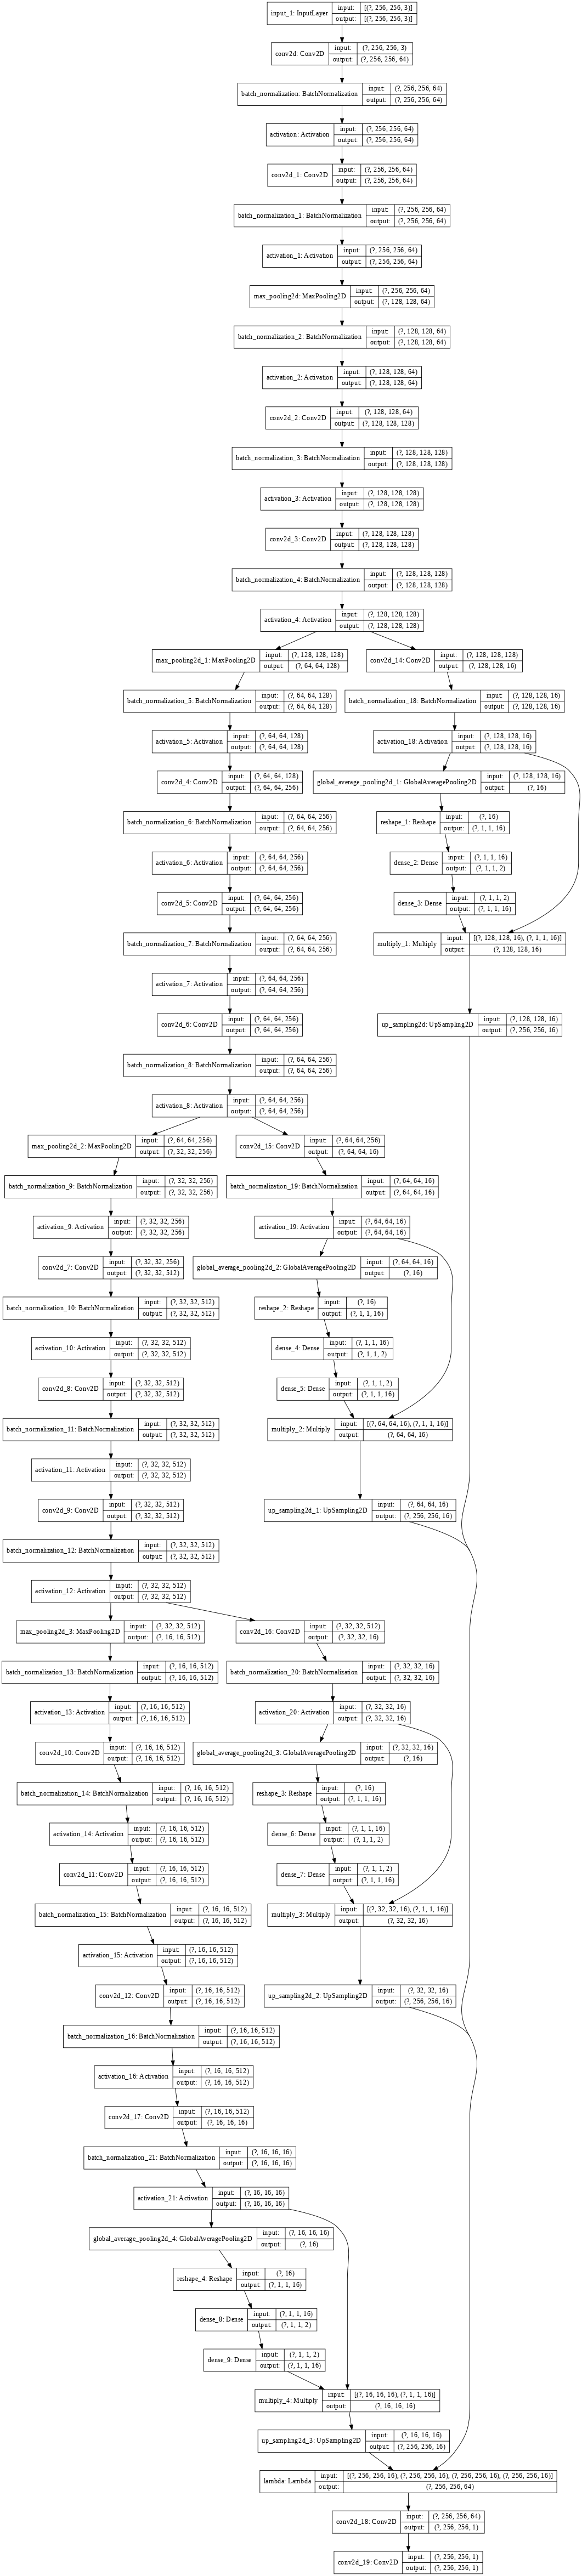

In [ ]:
tf.keras.utils.plot_model(modelDriu, show_shapes=True, dpi=64)

## Define tensorflow generators

In [21]:
from glob import glob

In [26]:
#PATH = 'UMNDatasetSplited/SplitPix2Pix/ManualFluid1/'

PATH = 'dukeImagesFluidROIReshSplited/pix2pixNoClean/'
PATH = 'UMNDatasetSplited/SplitPix2PixReshaped/ManualFluid1/'
#--PATH = 'dukeImagesFocosROIReshSplited/pix2pixNoClean/'
#PATH = 'oftalmoQuistesDarkImgs/pix2pixCleanedbm3dSigpt1/'
#PATH = 'oftalmoQuistesDarkImgs/pix2pixCleanedbm3dSig10/'
#PATH = 'oftalmoFocisDarkImgs/pix2pixNoClean/'
#PATH = 'oftalmoFocis/pix2pixNoClean/'
#PATH = 'oftalmoFluidsDarkImgs/pix2pixNoClean/'
PATH = 'oftalmoDrusenDarkImgs/pix2pixNoClean/'
PATH = 'oftalmoCystDarkImgs/pix2pixNoClean/'

In [27]:
image_list = sorted(glob(PATH + 'training/img/*'))
val_image_list = sorted(glob(PATH + 'validation/img/*'))
test_image_list = sorted(glob(PATH + 'test/img/*'))
print('Found', len(image_list), 'training images')
print('Found', len(test_image_list), 'test images')
print('Found', len(val_image_list), 'validation images')
print('Total', len(test_image_list) + len(val_image_list) + len(image_list) , 'test images')

Found 250 training images
Found 74 test images
Found 36 validation images
Total 360 test images


In [28]:
BUFFER_SIZE = 400
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [29]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

In [30]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [31]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [32]:
def normalize(input_image, real_image):
  input_image = (input_image / 255.0)
  #print(real_image.shape)
  real_image = tf.transpose(real_image, [2, 1,0])
  #print(real_image.shape)
  real_image = tf.expand_dims(real_image[0],0)
  #print(real_image.shape)
  real_image = tf.transpose(real_image, [2, 1,0])
  #print(real_image.shape)
  real_image = (real_image / 255.0)
  #input_image = tf.cast(input_image, dtype=tf.uint8)
  #real_image = tf.cast(real_image, dtype=tf.uint8)
  return input_image, real_image

In [33]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

<Figure size 432x288 with 0 Axes>

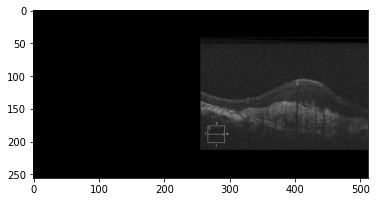

<Figure size 432x288 with 0 Axes>

In [ ]:
inputFile = PATH+'test/img/subject_0_1020180801172043OD1.jpg'
#inputFile = PATH+'test/img/subject_0_1120180801171755OD1VO.jpg'
inputFile = PATH+'test/img/subject_0_1020180801172043OD1VO.jpg'
inputFile = PATH+'test/img/subject_0_1020141114082511OD1VO.jpg'
inputFile = PATH+'test/img/subject_0_1020150318105810OD1VO.jpg'
#inputFile = PATH+'test/img/0_108_PCS59061OS.jpg'
image = tf.io.read_file(inputFile)
image = tf.image.decode_jpeg(image)
input_image = tf.cast(image, tf.float32)
plt.figure()
plt.imshow(input_image/255.0)
plt.figure()

In [ ]:
inp, re = load(inputFile)
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [34]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [35]:
def load_image_val(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [36]:
train_dataset = tf.data.Dataset.list_files(PATH+'training/img/*.jpg')
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [37]:
def generate_images( test_input, tar):
  #prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0]]
  targeta = np.asarray(tar[0])
  #print(targeta)
  #print(np.max(targeta))
  title = ['Input Image', 'Ground Truth']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    if display_list[i].shape[2] < 3:
      display_list[i] = tf.broadcast_to(display_list[i], [256, 256, 3])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

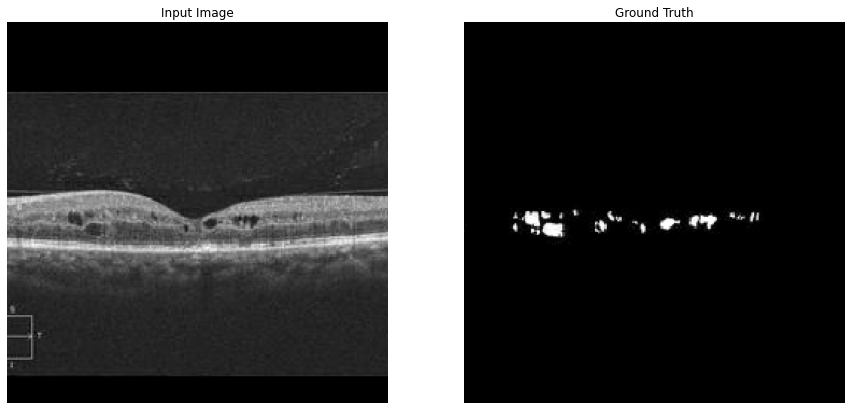

In [38]:
for example_input, example_target in train_dataset.take(1):
  generate_images( example_input, example_target)

## HyperParameter Exploration

#### Set own function to test

In [ ]:
from  datetime import datetime

In [ ]:
SMOOTH = 1e-5
def dice(im1, im2, empty_score=1.0,beta=1):
    smooth = SMOOTH
    #im1 = np.asarray(im1).astype(np.bool)
    #im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    #im_sum = im1.sum() + im2.sum()
    tp = im1 * im2
    tp = tp.sum()
    fp = im2.sum() - tp
    fn = im1.sum() - tp
    #if im_sum == 0:
     #   return empty_score

    #intersection = np.logical_and(im1, im2)
    score = (((1 + beta ** 2) * tp + smooth))/((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    #2. * intersection.sum() / im_sum
    #if score < 1 :
      #score = 2. * score
    return score

In [ ]:
def meanDicePerResults(results,Y_test):
  values = []
  #print("results shape 0 ",results.shape[0])
  for i in range(results.shape[0]):
    #print(i)
    y_scores = results[i].flatten()
    y_scores = y_scores.round()
    y_true = Y_test[i].flatten()
    y_true = y_true.round()
    dice_index = dice(y_true, y_scores)
    values.append(dice_index)
  #orderedvalues = np.argsort(values)
  return np.mean(values)

#### Set function to hyperparameter exploration 

In [ ]:
netDataSet = '/BATCHSEDRIUCorrect/FocisDarkOftalmo/'
netDataSet = '/BATCHSEDRIUCorrect/FluidsDarkOftalmo/'
netDataSet = '/BATCHSEDRIUCorrect/CystDarkOftalmo/'
#netDataSet = '/BATCHSEDRIUCorrect/DrusenDarkOftalmo/'
log_dir = "gdrive/MyDrive/OCTProject/HPARAMS" + netDataSet  + datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
best_weigths_dir = "gdrive/MyDrive/OCTProject/WEIGTHS" + netDataSet  + datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
#log_dir = "LOGS" + netDataSet  + datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
#best_weigths_dir = "WEIGTHS" + netDataSet  + datetime.now().strftime("%Y%m%d-%H%M%S") + "/"

In [ ]:
BATCH_TEST_SIZE = 200
test_dataset = tf.data.Dataset.list_files(PATH + '/validation/img/*.jpg')
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_TEST_SIZE)

In [ ]:
def train_test_model(hparams,log_dir,best_weigths_dir):
  optimizer_name = hparams[HP_OPTIMIZER]
  learning_rate = hparams[HP_L_RATE]
  loss_function_name = hparams[HP_LOSS]
  batch_size =  hparams[HP_B_SIZE]
  
  if loss_function_name == 'bce_jaccard':
    loss_function = sm.losses.bce_jaccard_loss
  elif loss_function_name == 'bce_dice':
    loss_function = sm.losses.bce_dice_loss
  else:
    raise ValueError("unexpected loss name: %r" % (loss_function_name,))

  if optimizer_name == "adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer_name == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
  
  train_dataset = tf.data.Dataset.list_files(PATH+'training/img/*.jpg')
  train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_dataset = train_dataset.shuffle(BUFFER_SIZE)
  train_dataset = train_dataset.batch(batch_size)
  train_dataset = train_dataset.repeat()
  train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

  val_dataset = tf.data.Dataset.list_files(PATH+'validation/img/*.jpg')
  #val_dataset = tf.data.Dataset.from_tensor_slices((image_list))
  val_dataset = val_dataset.map(load_image_val)
  val_dataset = val_dataset.batch(batch_size)
  val_dataset = val_dataset.repeat()
  val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

  if not os.path.exists(best_weigths_dir):
    os.makedirs(best_weigths_dir)

  checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weigths_dir + '/bestWeigths.hdf5', monitor='val_loss',verbose=0, save_best_only=True, mode='min')

  callbacks_list = [tf.keras.callbacks.TensorBoard(log_dir=log_dir),hp.KerasCallback(log_dir, hparams),checkpoint]
  
  modelDriu = createModelSEDRIU()

  modelDriu.compile(optimizer = optimizer,
                    loss = loss_function, 
                    metrics = ['accuracy',sm.metrics.f1_score,sm.metrics.iou_score])

  modelDriu.fit(train_dataset,
                       steps_per_epoch=len(image_list)//batch_size,
                       epochs=200,
                       verbose=0, # Suppress chatty output; use Tensorboard instead
                       validation_data=val_dataset,
                       validation_steps=len(val_image_list)//batch_size,
                       callbacks=callbacks_list
                       )
  
  modelDriu.save_weights(best_weigths_dir + '/lastWeigths.hdf5')
  modelDriu.load_weights(best_weigths_dir + '/bestWeigths.hdf5')
  
  #for x_test, y_test in test_dataset.take(1):
  #  f1score= modelDriu.evaluate(x_test, y_test)
  #print(" test scores ",f1score)
  #return f1score[2]
  for x_test, y_test in test_dataset.take(1):
    prediction = modelDriu.predict(x_test)
  y_test = np.asarray(y_test)
  x_test = np.asarray(x_test)
  prediction = np.asarray(prediction)
  f1score = meanDicePerResults(prediction,y_test)
  print(" test scores ",f1score)
  return f1score

In [ ]:
def run(run_dir, hparams,weigths_dir):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams,run_dir,weigths_dir)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
def generateLearningRatesCenter(lrs, number,secondBest):
  index = lrs.index(number)
  if index < 0:
      raise ValueError("Index to center not found")
  lrsCenter = np.logspace(np.log10(lrs[index-1]), np.log10(lrs[index+1]), base = 10, num = 5).tolist()
  lrsCenter[0] = secondBest
  lrsCenter[-1] = np.logspace(np.log10(number), np.log10(secondBest), base = 10, num = 5).tolist()[3]
  return lrsCenter

In [ ]:
#0.003  0.00011
#0.0005 0.0003
#0.0000001 0.001
#np.log10(0.0001), np.log10(0.003)
#np.log10(0.0009), np.log10(0.002)
#np.log10(1e-7), np.log10(1e-2)
lrs = np.logspace(np.log10(1e-6), np.log10(1e-3), base = 10, num = 25).tolist()
#lrs = lrs[19:]
BZS = [16]

In [ ]:
#!rm -rf ./gdrive/MyDrive/OCTProject/HPARAMS/BATCHSEDRIUCorrect/CystDarkOftalmo/
#!rm -rf ./gdrive/MyDrive/OCTProject/WEIGTHS/BATCHSEDRIUCorrect/CystDarkOftalmo/

In [ ]:
lrs2 = generateLearningRatesCenter(lrs,5.623413251903491e-05,0.0001)
BZS = np.linspace(2, 16, num=5,dtype=np.int16).tolist()

In [ ]:
print(lrs2)

[0.0001, 4.869675251658631e-05, 5.623413251903491e-05, 6.493816315762113e-05, 8.659643233600654e-05]


In [ ]:
print(lrs)

[1e-06, 1.333521432163324e-06, 1.778279410038923e-06, 2.3713737056616552e-06, 3.162277660168379e-06, 4.216965034285822e-06, 5.623413251903491e-06, 7.498942093324558e-06, 1e-05, 1.333521432163324e-05, 1.778279410038923e-05, 2.3713737056616554e-05, 3.1622776601683795e-05, 4.216965034285822e-05, 5.623413251903491e-05, 7.498942093324559e-05, 0.0001, 0.0001333521432163324, 0.00017782794100389227, 0.00023713737056616554, 0.00031622776601683794, 0.00042169650342858224, 0.0005623413251903491, 0.0007498942093324559, 0.001]


In [ ]:
session_num = 0
#HP_L_RATE = hp.HParam('learning_rate', hp.Discrete([1e-3,1e-4,1e-5,1e-6]))
#HP_LOSS = hp.HParam('loss_function',hp.Discrete(['bce_jaccard','bce_dice']))
#HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
METRIC_ACCURACY = 'f1-score'
HP_L_RATE = hp.HParam('learning_rate', hp.Discrete(lrs2))
HP_LOSS = hp.HParam('loss_function',hp.Discrete(['bce_dice'])) #'bce_jaccard',
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam'])) #, 'sgd'
HP_B_SIZE = hp.HParam('batch_size', hp.Discrete(BZS)) #, 'sgd'

with tf.summary.create_file_writer(log_dir).as_default():
  hp.hparams_config(
    hparams=[HP_L_RATE, HP_LOSS, HP_OPTIMIZER,HP_B_SIZE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='valF1score')]
  )


for l_rates in HP_L_RATE.domain.values:
  for loss in HP_LOSS.domain.values:
    for optimizer in HP_OPTIMIZER.domain.values:
      for batchS in HP_B_SIZE.domain.values:
        hparams = {
            HP_L_RATE: l_rates,
            HP_LOSS : loss,
            HP_OPTIMIZER: optimizer,
            HP_B_SIZE: batchS
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run(log_dir + run_name, hparams,best_weigths_dir + run_name)
        session_num += 1

--- Starting trial: run-0
{'learning_rate': 4.869675251658631e-05, 'loss_function': 'bce_dice', 'optimizer': 'adam', 'batch_size': 2}
 test scores  0.4705891885049186
--- Starting trial: run-1
{'learning_rate': 4.869675251658631e-05, 'loss_function': 'bce_dice', 'optimizer': 'adam', 'batch_size': 5}
 test scores  0.5003170276925825
--- Starting trial: run-2
{'learning_rate': 4.869675251658631e-05, 'loss_function': 'bce_dice', 'optimizer': 'adam', 'batch_size': 9}
 test scores  0.6051390172876852
--- Starting trial: run-3
{'learning_rate': 4.869675251658631e-05, 'loss_function': 'bce_dice', 'optimizer': 'adam', 'batch_size': 12}
 test scores  0.5621330539041081
--- Starting trial: run-4
{'learning_rate': 4.869675251658631e-05, 'loss_function': 'bce_dice', 'optimizer': 'adam', 'batch_size': 16}
 test scores  0.5311787527955333
--- Starting trial: run-5
{'learning_rate': 5.623413251903491e-05, 'loss_function': 'bce_dice', 'optimizer': 'adam', 'batch_size': 2}
 test scores  0.4705891885049

In [ ]:
!mkdir -p gdrive/MyDrive/OCTProject/HPARAMS/BATCHSEDRIU/CystDarkOftalmo/20210306-185811/
!cp -r ./LOGS/BATCHSEDRIU/CystDarkOftalmo/20210306-185811/. gdrive/MyDrive/OCTProject/HPARAMS/BATCHSEDRIU/CystDarkOftalmo/20210306-185811/
!mkdir -p gdrive/MyDrive/OCTProject/WEIGTHS/BATCHSEDRIU/CystDarkOftalmo/20210306-185811/
!cp -r ./WEIGTHS/BATCHSEDRIU/CystDarkOftalmo/20210306-185811/. gdrive/MyDrive/OCTProject/WEIGTHS/BATCHSEDRIU/CystDarkOftalmo/20210306-185811/

In [ ]:
!rm -rf ./LOGS
!rm -rf ./WEIGTHS

## Train model common way

In [ ]:
def train_test_model(hparams):
  optimizer_name = hparams[HP_OPTIMIZER]
  learning_rate = hparams[HP_L_RATE]
  loss_function_name = hparams[HP_LOSS]
  if loss_function_name == 'bce_jaccard':
    loss_function = sm.losses.bce_jaccard_loss
  elif loss_function_name == 'bce_dice':
    loss_function = sm.losses.bce_dice_loss
  else:
    raise ValueError("unexpected loss name: %r" % (loss_function_name,))

  if optimizer_name == "adam":
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  elif optimizer_name == "sgd":
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  else:
    raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))

  modelDriu.compile(optimizer = optimizer,
                    loss = loss_function, 
                    metrics = sm.metrics.f1_score)
  
  history = modelDriu.fit(inputgenerator,
                       steps_per_epoch=566 // batch_size,
                       epochs=50,
                       validation_data=validationgenerator,
                       validation_steps=146 // batch_size,
                       callbacks=[tf.keras.callbacks.TensorBoard(log_dir=log_dir),
                                  hp.KerasCallback(log_dir, hparams),]
                       )
  x_test, y_test = next(testgenerator)
  _, f1score = modelDriu.evaluate(x_test, y_test)
  return f1score

## Focis Dark images

### 20210530-172947
<br>
lr 5.623413251903491e-05 bz 16-> 0.56645
<br>
lr  0.0001  bz 16 -> 0.54648
<br>
lr 0.00031622776601683794 16 bz -> 0.54278

### 20210830-031504
<br>
lr 4.869675251658631e-05 bz 9 -> 0.60514 - run-2
<br>
lr 8.659643233600654e-05 bz 9 -> 0.57711
<br>

## Fluids Dark OFTALMOCENTER

### 20210511-135746
<br>
lr 0.00017782794100389227 bz 16-> 0.65871
<br>
lr 0.0005623413251903491  bz 16 -> 0.65182
<br>
lr 7.498942093324559e-05 bz -> 0.65078

### 20210511-193543
<br>
lr 0.0005623413251903491 bz 5-> 0.66615 ->run-21
<br>
lr 0.00017782794100389227  bz 5 -> 0.66073
<br>
lr 0.0001539926526059492 bz 16 -> 0.65906


## Cyst Dark OFTALMOCENTER

### 20210513-204414

<br>
lr 4.216965034285822e-05 bz 16-> 0.85498    
<br>
lr 0.0007498942093324559 bz 16-> 0.84859
<br>
lr 7.498942093324558e-06 bz 16 -> 0.84069


### 20210517-232634

<br>
lr 0.00036517 bz 12-> 0.86232   run-18 
<br>
lr 0.00074989 bz 9-> 0.85897
<br>
lr 0.00036517 bz 16 -> 0.85534



## Drusen Dark OFTALMOCENTER

### 20210517-165619

<br>
lr 3.1622776601683795e-05 bz 16-> 0.63742  
<br>
lr 0.0005623413251903491 bz 16-> 0.62242
<br>
lr 0.00023713737056616554 bz 16 -> 0.62056


### 20210530-172512

<br>
lr 0.00027384 bz 9-> 0.66709  -> run-17
<br>
lr 0.000027384 bz 5-> 0.65643
<br>
lr 0.000027384 bz 2 -> 0.65327



In [ ]:
#!rm -rf gdrive/MyDrive/OCTProject/HPARAMS/SEDRIU/FocisDarkOftalmo/20210218-184043

In [ ]:
%load_ext  tensorboard

In [ ]:
print(lrs)

[1e-06, 1.333521432163324e-06, 1.778279410038923e-06, 2.3713737056616552e-06, 3.162277660168379e-06, 4.216965034285822e-06, 5.623413251903491e-06, 7.498942093324558e-06, 1e-05, 1.333521432163324e-05, 1.778279410038923e-05, 2.3713737056616554e-05, 3.1622776601683795e-05, 4.216965034285822e-05, 5.623413251903491e-05, 7.498942093324559e-05, 0.0001, 0.0001333521432163324, 0.00017782794100389227, 0.00023713737056616554, 0.00031622776601683794, 0.00042169650342858224, 0.0005623413251903491, 0.0007498942093324559, 0.001]


In [ ]:
#%tensorboard --logdir logs/fit
#%tensorboard --logdir gdrive/'My Drive'/OCTProject/HPARAMS/DRIU/20201101-232624
#%tensorboard --logdir gdrive/MyDrive/OCTProject/HPARAMS/SEDRIU/FluidsDarkOftalmo/20210215-071021
#gdrive/MyDrive/OCTProject/HPARAMS/BATCHSEDRIUCorrect/FocisDarkOftalmo/20210505-131042
# gdrive/MyDrive/OCTProject/HPARAMS/BATCHSEDRIUCorrect/DrusenDarkOftalmo/20210530-172512
##--logdir gdrive/MyDrive/OCTProject/HPARAMS/BATCHSEDRIUCorrect/CystDarkOftalmo/20210517-232634
%tensorboard --logdir gdrive/MyDrive/OCTProject/HPARAMS/BATCHSEDRIUCorrect/CystDarkOftalmo/20210517-232634

In [ ]:
#OUTPUT_WEIGHTS_PATH = "./bestSSE3Pix2PixCleanedEp150_bce_dice.h5"
#!cp DriuTF2_256ep150Cleaned.h5 ./gdrive/My\ Drive/OCTProject/ResumeWeigths20200628/
root_path = './gdrive/My\ Drive/OCTProject/HPARAMS/DRIU'
!cp -r ./logs/hparam_tuning {root_path}

cp: cannot stat './logs/hparam_tuning': No such file or directory


In [ ]:
!cp ./DriuTF2_256ep150NoCleaningFocosDuke.h5 ./gdrive/My\ Drive/OCTProject/weigths/weigthsSIPAIM

In [ ]:
import time
from datetime import datetime

In [ ]:
log_dir = "logs/fit/"  + datetime.now().strftime("%Y%m%d-%H%M%S")
#file_writer = tf.summary.create_file_writer(logdir + "/metrics")
#file_writer.set_as_default()

In [ ]:
OUTPUT_WEIGHTS_PATH = "top_weigts.hdf5"

In [ ]:
#checkpoint = tf.keras.callbacks.ModelCheckpoint(OUTPUT_WEIGHTS_PATH, monitor='val_f1-score',verbose=1, save_best_only=True, mode='max')
checkpoint = tf.keras.callbacks.ModelCheckpoint(OUTPUT_WEIGHTS_PATH, monitor='val_loss',verbose=1, save_best_only=True, mode='min')
#csv_logger = CSVLogger('./log.out', append=True, separator=';')

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f1-score', verbose = 1,
                              min_delta = 0.01, patience = 3, mode = 'max')

#callbacks_list = [checkpoint, csv_logger,tensorboard_callback]
callbacks_list = [tensorboard_callback,checkpoint]

In [ ]:
modelDriu = createModelSEDRIU()

In [ ]:
modelDriu.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=8.25404185268019e-05),
                    loss = sm.losses.bce_dice_loss,
                  metrics = [sm.metrics.iou_score, sm.metrics.f1_score])
batch_size = 1

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'training/img/*.jpg')
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.list_files(PATH+'validation/img/*.jpg')
#val_dataset = tf.data.Dataset.from_tensor_slices((image_list))
val_dataset = val_dataset.map(load_image_val)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
#history = modelDriu.fit(inputgenerator,
#                       steps_per_epoch=420 // batch_size,
#                       epochs=150,
#                       validation_data=validationgenerator,
#                       validation_steps=108 // batch_size,
#                       callbacks=callbacks_list
#                       )
history = modelDriu.fit(train_dataset,
                       steps_per_epoch=len(image_list)//batch_size,
                       epochs=600,
                       validation_data=val_dataset,
                       validation_steps=len(val_image_list)//batch_size,
                       callbacks=callbacks_list
                       )
#OUTPUT_WEIGHTS_PATH = "./" + OUTPUT_WEIGHTS_PATH
#time.sleep(120)
#!cp {OUTPUT_WEIGHTS_PATH} {root_path}

In [ ]:
for x_test, y_test in test_dataset.take(1):
  prediction = modelDriu.predict(x_test)
y_test = np.asarray(y_test)
x_test = np.asarray(x_test)
prediction = np.asarray(prediction)
f1score = meanDicePerResults(prediction,y_test)
print(" test scores ",f1score)

 test scores  0.5859537333603287


In [ ]:
modelDriu.save_weights('SEDRIU_AFTER_HYPERPARAMETER_400.hdf5')

In [ ]:
pathw = './gdrive/MyDrive/OCTProject/AfterParameterExploration/DRIU/FocisDarkImgs/weigths/'
pathw = ''

In [ ]:
modelDriu.load_weights(pathw + 'SEDRIU_AFTER_HYPERPARAMETER_400.hdf5')

In [ ]:
for x_test, y_test in test_dataset.take(1):
    f1score= modelDriu.evaluate(x_test, y_test)
print(" test scores ",f1score," F1 SCORE ",f1score[2])

72/72 [==============================] - 0s 4ms/sample - loss: 0.0973 - iou_score: 0.8404 - f1-score: 0.9131
 test scores  [0.09728223582108815, 0.84037685, 0.9131143]  F1 SCORE  0.9131143


In [ ]:
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('F1-Score')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plt.plot(history.history['jacard_coef'])
#plt.plot(history.history['val_jacard_coef'])
#plt.title('model jacard')
#plt.ylabel('Jacard')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()

#plt.plot(history.history['dice_coef'])
#plt.plot(history.history['val_dice_coef'])
#plt.title('model Dice')
#plt.ylabel('Dice')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()

## Evaluate just with tensorflow generator

In [69]:
pathw = './gdrive/MyDrive/OCTProject/WEIGTHS/BATCHSEDRIUCorrect/FocisDarkOftalmo/20210830-031504/run-2/'
pathw = './gdrive/MyDrive/OCTProject/WEIGTHS/BATCHSEDRIUCorrect/FluidsDarkOftalmo/20210511-193543/run-21/'
pathw = './gdrive/MyDrive/OCTProject/WEIGTHS/BATCHSEDRIUCorrect/DrusenDarkOftalmo/20210530-172512/run-17/'
pathw = './gdrive/MyDrive/OCTProject/WEIGTHS/BATCHSEDRIUCorrect/CystDarkOftalmo/20210517-232634/run-18/'

In [70]:
modelDriu = createModelSEDRIU()

In [71]:
modelDriu.load_weights(pathw + 'bestWeigths.hdf5')

In [87]:
BATCH_TEST_SIZE = 200
test_dataset = tf.data.Dataset.list_files(PATH + 'test/img/*.jpg')
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.batch(BATCH_TEST_SIZE)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [88]:
for x_test, y_test in test_dataset.take(1):
    prediction= modelDriu.predict(x_test)

In [89]:
print(prediction.shape)

(74, 256, 256, 1)


In [90]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [91]:
SMOOTH = 1e-5
def dice(im1, im2, empty_score=1.0,beta=1):
    smooth = SMOOTH
    #im1 = np.asarray(im1).astype(np.bool)
    #im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    #im_sum = im1.sum() + im2.sum()
    tp = im1 * im2
    tp = tp.sum()
    fp = im2.sum() - tp
    fn = im1.sum() - tp
    #if im_sum == 0:
     #   return empty_score

    #intersection = np.logical_and(im1, im2)
    score = (((1 + beta ** 2) * tp + smooth))/((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    #2. * intersection.sum() / im_sum
    #if score < 1 :
      #score = 2. * score
    return score

In [92]:
def jaccard(x,y):
  x = np.asarray(x, np.bool) # Not necessary, if you keep your data
  y = np.asarray(y, np.bool) # in a boolean array already!
  return np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum()) 

In [93]:
def meanJaccardPerResults(results):
  less_value = 1
  better_result = 0
  worst_case = 0
  mean_confussion = np.zeros((2,2))
  values = []
  for i in range(results.shape[0]):
    y_scores = results[i].flatten()
    y_scores = y_scores.round()
    y_true = y_test[i].flatten()
    y_true = y_true.round()
    confusion = confusion_matrix(y_true.round(), y_scores.round())
    if confusion.shape[0] == 1:
      new = np.zeros((2,2))
      new[0][0]=confusion[0][0]
      confusion = new
    mean_confussion = mean_confussion + confusion
    jaccard_index = jaccard_score(y_true, y_scores)
    #jaccard_index = jaccard(y_true, y_scores)
    #print(jaccard_index)
    #if jaccard_index > 0:
    values.append(jaccard_index)
  mean_confussion = mean_confussion/results.shape[0]
  orderedvalues = np.argsort(values)
  print(orderedvalues)
  return mean_confussion,orderedvalues,values

In [94]:
def meanDicePerResults(results,Y_test):
  values = []
  for i in range(results.shape[0]):
    y_scores = results[i].flatten()
    y_scores = y_scores.round()
    y_true = Y_test[i].flatten()
    y_true = y_true.round()
    dice_index = dice(y_true, y_scores)
    values.append(dice_index)
  orderedvalues = np.argsort(values)
  return orderedvalues,values

In [95]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

In [96]:
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
def matrix(mean_confussion):
  binary = mean_confussion.astype(int)
  print(binary)
  fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True)
#plt.show()

In [97]:
y_test = np.asarray(y_test)
x_test = np.asarray(x_test)
prediction = np.asarray(prediction)

In [98]:
confussionDRIU,ovDRIU,vDRIU = meanJaccardPerResults(prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[36 23 24 25 26 27 54 53 31 43 49 48 35 72 37 47 46 41 42 33 21 55 19  1
  2  3  4  5 69 66  8 20  9 63 62 13 15 16 17 57 10 45 50 59 39  0 51 18
 11 64 61 68 58  6 32 65 60 34 12 70  7 22 30 40 52 28 38 29 73 44 14 56
 67 71]


[[64547   103]
 [  289   595]]


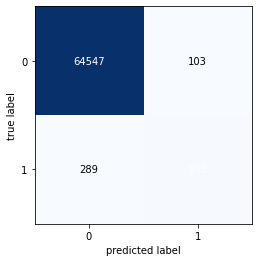

In [99]:
matrix(confussionDRIU)

In [100]:
orderValDiceDRIU,valDiceDRIU = meanDicePerResults(prediction,y_test)

In [101]:
print("mean jaccard SE unet",np.mean(vDRIU))
print("mean dice SE unet",np.mean(valDiceDRIU))
#umn entire
#0.9151518296119213
#0.9173
#0.9140 top_weigts_driu2.hdf5
#0.9135 DRIU_AFTER_HYPERPARAMETER_200.hdf5
#0.9114 top_weigts_driu.hdf5

mean jaccard SE unet 0.2976098060881945
mean dice SE unet 0.7795600427780165


In [ ]:
def get_one_image(imageNumber,jaccardValue,results):
  fig = plt.figure(figsize=(9, 4))
  ax = fig.add_subplot(1, 3, 1)
  Y_toPlot = results[imageNumber]
  img2 = np.zeros((Y_toPlot.shape[0],Y_toPlot.shape[1])+(3,))
  data = np.rollaxis(Y_toPlot, -1, 0)
  img2[:,:,0] = data[0]
  img2[:,:,1] = data[0]
  img2[:,:,2] = data[0]
  ax.imshow(img2, cmap=plt.cm.Greys_r)
  ax.set_title('Dice val ' + str(round(jaccardValue,2)))
  ax = fig.add_subplot(1, 3, 2)
  Y_toPlot = y_test[imageNumber]
  img2 = np.zeros((Y_toPlot.shape[0],Y_toPlot.shape[1])+(3,))
  data = np.rollaxis(Y_toPlot, -1, 0)
  img2[:,:,0] = data[0]
  img2[:,:,1] = data[0]
  img2[:,:,2] = data[0]
  ax.imshow(img2, cmap=plt.cm.Greys_r)
  ax.set_title('Correct' + str(imageNumber))
  ax = fig.add_subplot(1, 3, 3)
  ax.imshow(x_test[i])
  ax.set_title('Image')
  plt.show()

In [ ]:
print(valDiceDRIU)

[1.0, 1.0, 0.3096446875724699, 2.2222217283951715e-07, 1.0, 1.492537090666106e-07, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1904760487528514e-07, 2.1276595291987337e-08, 0.7396061288139597, 9.900989118713949e-08, 1.0, 0.6966292220047972, 2.1276591217746549e-07, 0.9229661632615827, 0.9027237359492845, 1.0, 0.7633136164700113, 1.0, 1.0, 1.0, 0.9118483416500077, 0.7916666753472219, 2.6315782548478277e-07, 0.11881196843445857, 0.18613139181185284, 0.9461697728139775, 1.0, 0.935720097901871, 1.0, 1.3888886959876811e-07, 0.9645909646774335, 1.0, 1.0, 1.0, 0.7286063636037564, 0.5037037053020814, 1.0, 4.504504301598906e-08, 1.0, 1.7241376337693735e-07, 1.0, 1.0, 3.039513585425119e-08, 1.0, 1.0, 1.0, 2.6525198235405886e-08, 0.40977444718469086, 9.803920607458764e-08, 1.960783929258053e-07, 1.0, 1.0, 1.0, 9.433961374154588e-08, 1.0, 0.7936508264046307, 0.5866364712725202, 0.7385019745269122, 0.742596816797339, 1.0, 1.0, 2.777777006173054e-07, 1.1363635072314196e-07, 0.9104704103909681]


In [ ]:
for i,val in enumerate(valDiceDRIU):
  get_one_image(i,val,prediction)

Output hidden; open in https://colab.research.google.com to view.

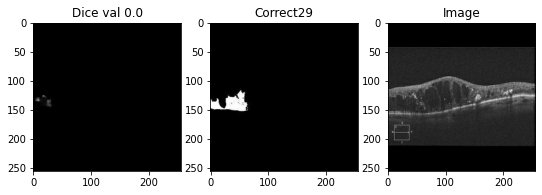

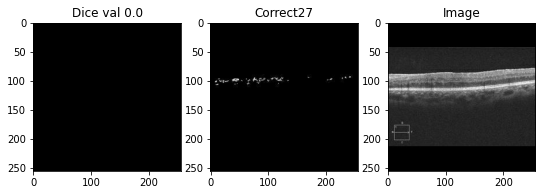

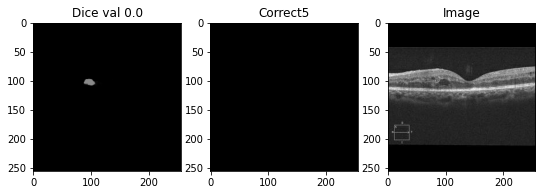

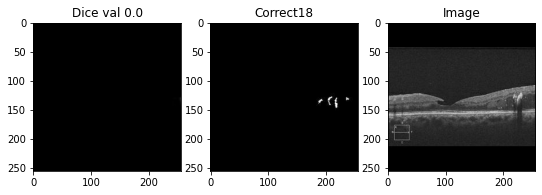

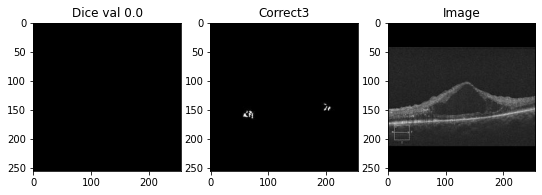

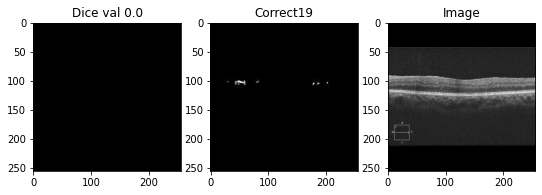

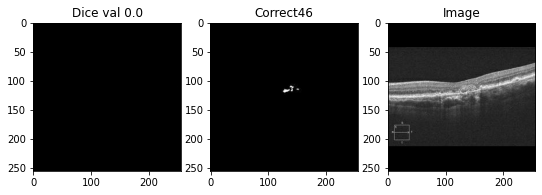

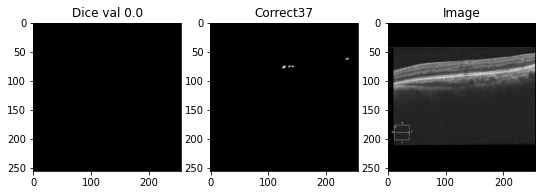

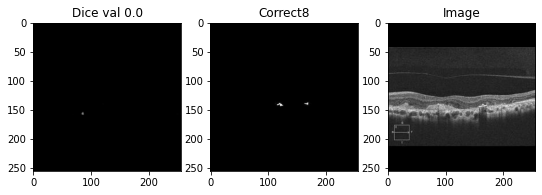

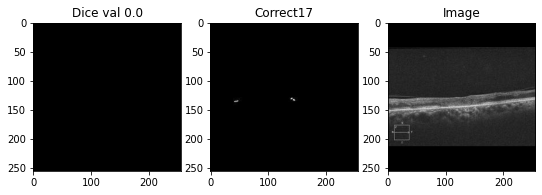

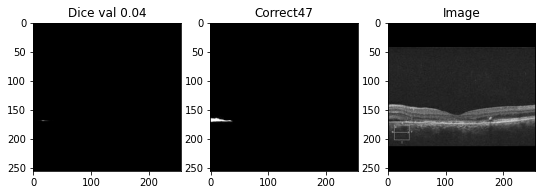

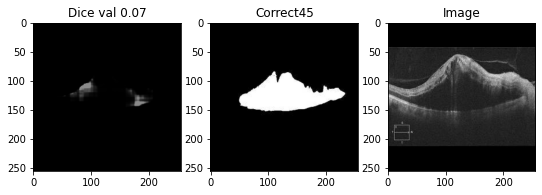

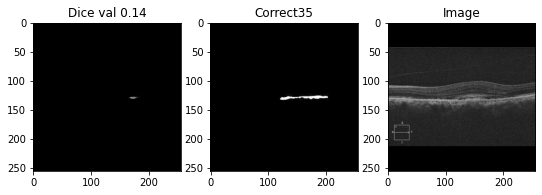

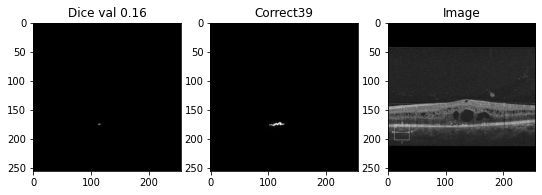

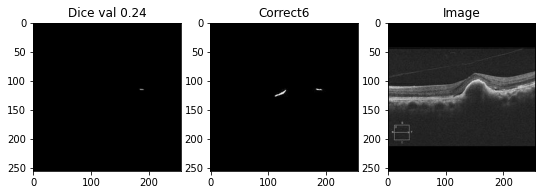

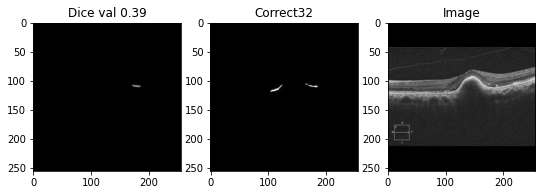

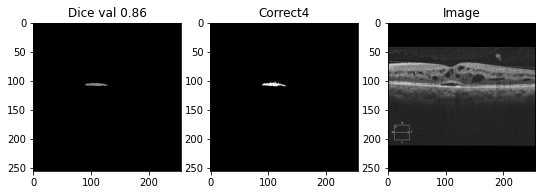

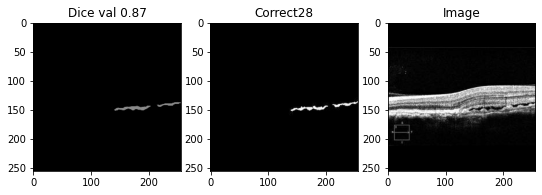

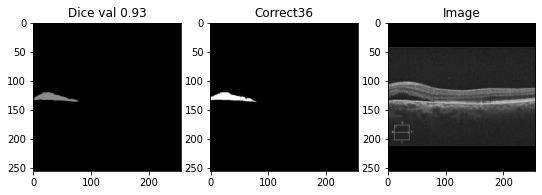

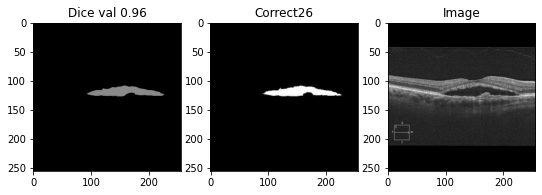

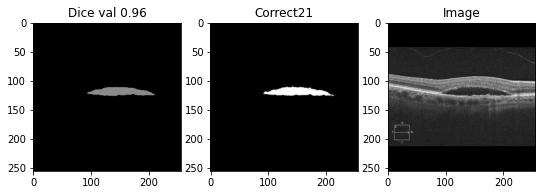

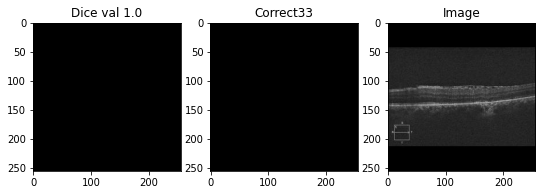

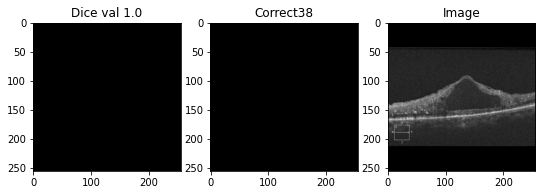

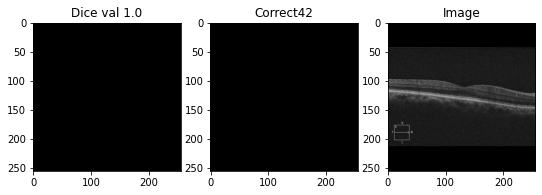

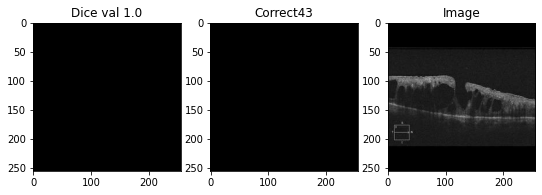

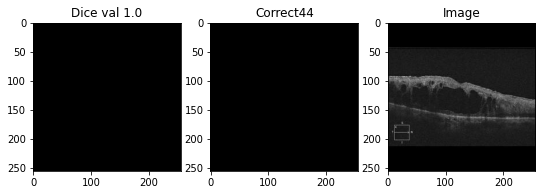

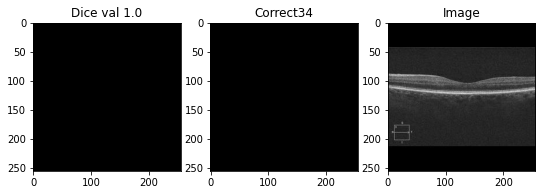

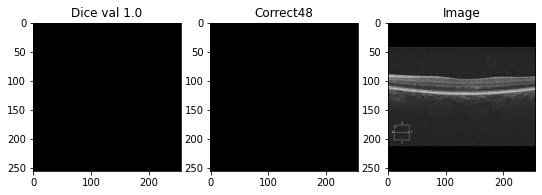

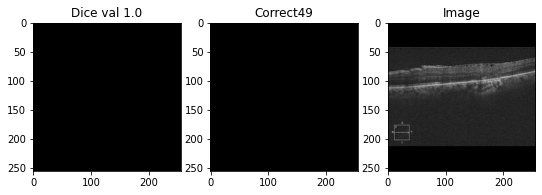

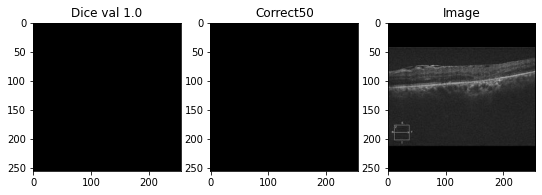

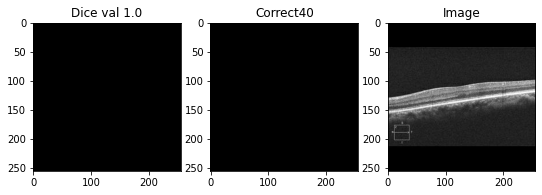

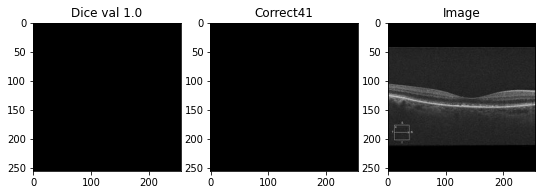

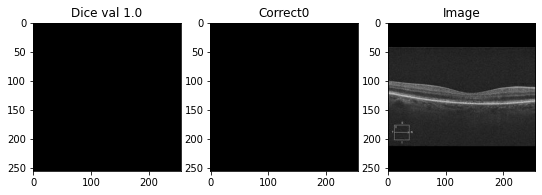

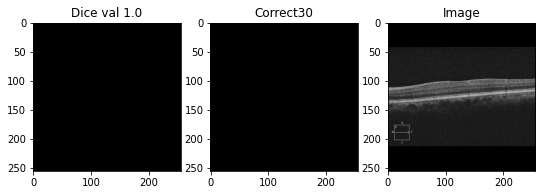

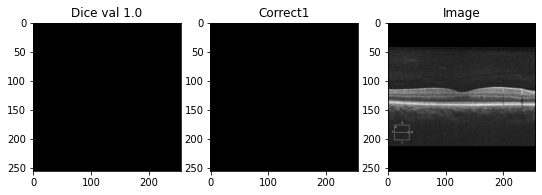

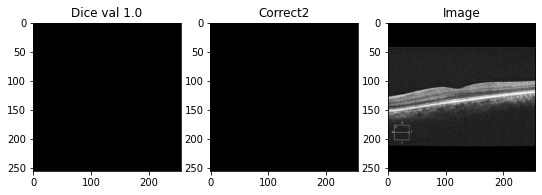

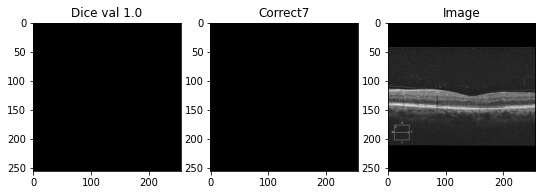

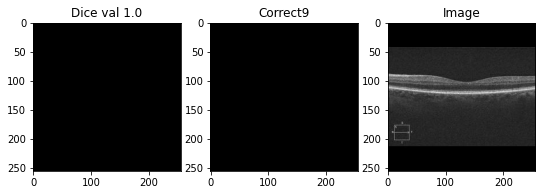

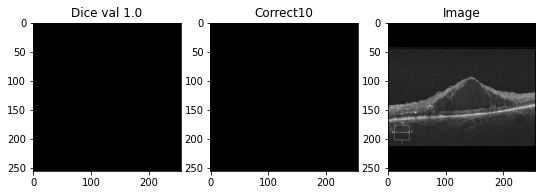

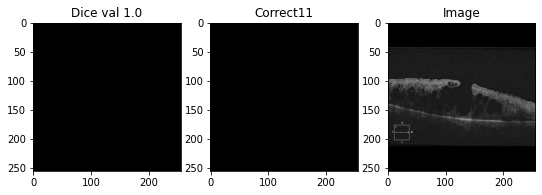

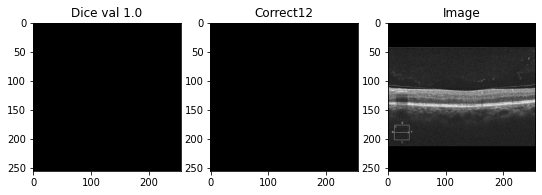

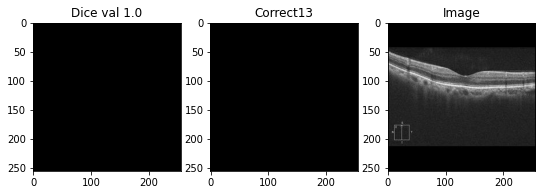

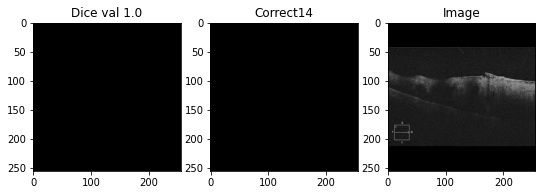

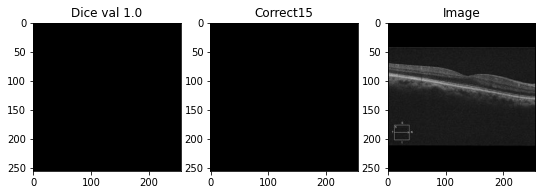

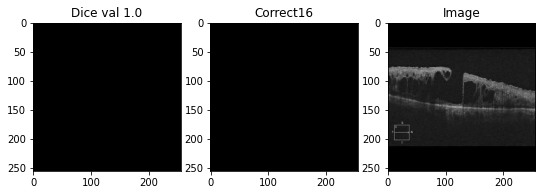

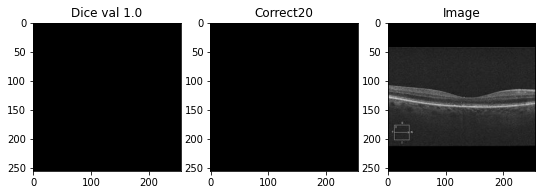

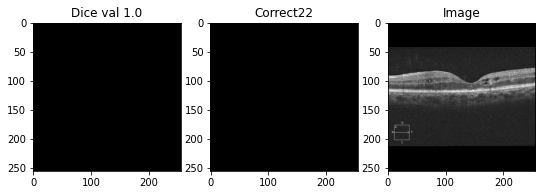

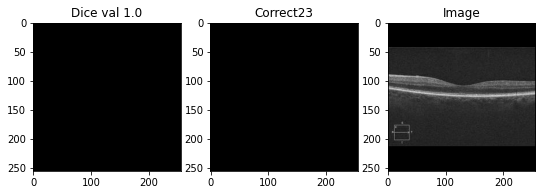

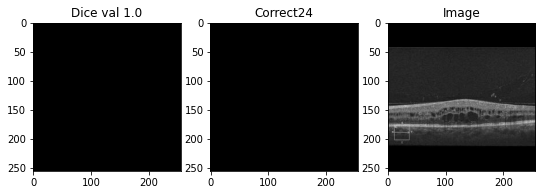

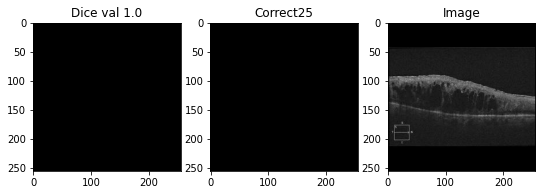

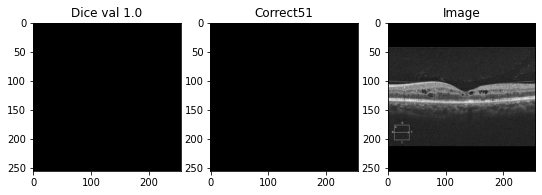

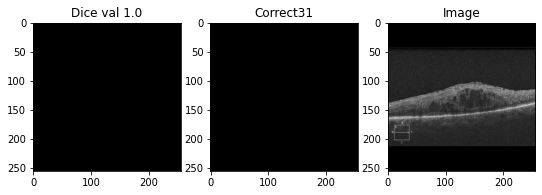

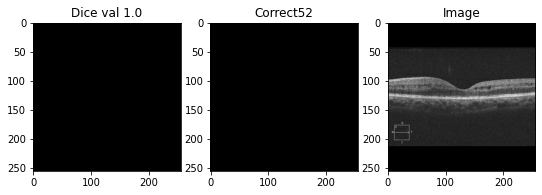

In [ ]:
for i in orderValDiceDRIU:
  get_one_image(i,valDiceDRIU[i],prediction)

In [ ]:
from PIL import Image
import os

In [ ]:
mainPathSavePr = './SEDRIUImagesPrediction/'
realImgs = mainPathSavePr + 'realImg/'
predictionImgs = mainPathSavePr + 'predictionsImg/'
maskFluid = mainPathSavePr +'quistmask/'

In [ ]:
def save_one_image(idx,imageNumber,jaccardValue,results):
  if not os.path.exists(realImgs):
    os.makedirs(realImgs)
  if not os.path.exists(predictionImgs):
    os.makedirs(predictionImgs)
  if not os.path.exists(maskFluid):
    os.makedirs(maskFluid)

  Y_toPlot = np.round(results[imageNumber])
  img2 = np.zeros((Y_toPlot.shape[0],Y_toPlot.shape[1])+(3,))
  data = np.rollaxis(Y_toPlot, -1, 0)
  img2[:,:,0] = data[0]
  img2[:,:,1] = data[0]
  img2[:,:,2] = data[0]
  #print(img2)
  img = tf.keras.preprocessing.image.array_to_img(img2)
  tf.keras.preprocessing.image.save_img(predictionImgs +str(idx)+ '.jpg',img)
  #im.save(predictionImgs +imageNumber+ '.jpg')

  Y_toPlot = y_test[imageNumber]
  img2 = np.zeros((Y_toPlot.shape[0],Y_toPlot.shape[1])+(3,))
  data = np.rollaxis(Y_toPlot, -1, 0)
  img2[:,:,0] = data[0]
  img2[:,:,1] = data[0]
  img2[:,:,2] = data[0]
  img = tf.keras.preprocessing.image.array_to_img(img2)
  tf.keras.preprocessing.image.save_img(maskFluid +str(idx)+ '.jpg',img)

  img = tf.keras.preprocessing.image.array_to_img(x_test[i])
  tf.keras.preprocessing.image.save_img(realImgs +str(idx)+ '.jpg',img)
  #im = Image.fromarray(x_test[i])
  #im.save(realImgs +imageNumber+ '.jpg')


In [ ]:
for idx,i in enumerate(orderValDiceDRIU):
  #print(idx,i)
  save_one_image(idx,i,valDiceDRIU[i],prediction)

In [ ]:
PATH_TO_SAVE = './gdrive/MyDrive/OCTProject/AfterParameterExploration/SEDRIU/FocisDarkImgs/'

In [ ]:
PATH_TO_SAVE = './gdrive/MyDrive/OCTProject/FocisImagesBestModel/'

In [ ]:
!mkdir -p {PATH_TO_SAVE + 'weigths'}

In [ ]:
 #!cp ./DRIU_AFTER_HYPERPARAMETER_200.hdf5 {PATH_TO_SAVE + 'weigths' }
 !cp ./SEDRIU_AFTER_HYPERPARAMETER_200.hdf5 {PATH_TO_SAVE + 'weigths' }

In [ ]:
!cp -r  ./SEDRIUImagesPrediction {PATH_TO_SAVE}

### Evaluate another approach

In [ ]:
file_id = '1QERUoGFnXhERGPgC7sVv0N3MjFFnwGkW'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])

In [ ]:
validationgenerator=generate_generator_multiple(validation_datagen,
                                          dir1=validation_data_dir,
                                          dir2=validation_mask_data_dir,
                                          batch_size=200,
                                          img_height=256,
                                          img_width=256) 

testgenerator=generate_generator_multiple(test_datagen,
                                          dir1=test_data_dir,
                                          dir2=test_mask_data_dir,
                                          batch_size=100,
                                          img_height=256,
                                          img_width=256)

In [ ]:
modelDriu.save_weights('DriuTF2_256ep150NoCleaning.h5')

In [ ]:
file_id = '1-1N9X0hbxV9kZLyMJQwCfGdwX3lqGm2Q'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])
modelDriu.load_weights('DriuTF2_256ep150NoCleaningFluidDuke.h5')

In [ ]:
file_id = '1-Ez5E29yY9Qn-DF2j18U_HVufHsH-MPh'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])
modelDriu.load_weights('DriuTF2_256ep150NoCleaningFocosDuke.h5')

In [ ]:
X_test, Y_test = next(testgenerator)

Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


In [ ]:
X_test, Y_test = next(validationgenerator)

Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.


In [ ]:
print(X_test.shape,Y_test.shape)

(42, 256, 256, 3) (42, 256, 256, 1)


In [ ]:
results = modelDriu.predict(X_test)

In [ ]:
print(results.shape)

(42, 256, 256, 1)


In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
def jaccard(x,y):
  x = np.asarray(x, np.bool) # Not necessary, if you keep your data
  y = np.asarray(y, np.bool) # in a boolean array already!
  return np.double(np.bitwise_and(x, y).sum()) / np.double(np.bitwise_or(x, y).sum())

In [ ]:
def meanJaccardPerResults(results):
  less_value = 1
  better_result = 0
  worst_case = 0
  mean_confussion = np.zeros((2,2))
  values = []
  for i in range(results.shape[0]):
    y_scores = results[i].flatten()
    y_scores = y_scores.round()
    y_true = Y_test[i].flatten()
    y_true = y_true.round()
    confusion = confusion_matrix(y_true.round(), y_scores.round())
    if confusion.shape[0] == 1:
      new = np.zeros((2,2))
      new[0][0]=confusion[0][0]
      confusion = new
    mean_confussion = mean_confussion + confusion
    jaccard_index = jaccard_score(y_true, y_scores)
    #jaccard_index = jaccard(y_true, y_scores)
    #print(jaccard_index)
    #if jaccard_index > 0:
    values.append(jaccard_index)
  mean_confussion = mean_confussion/results.shape[0]
  orderedvalues = np.argsort(values)
  print(orderedvalues)
  return mean_confussion,orderedvalues,values

In [ ]:
def dice(im1, im2, empty_score=1.0):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [ ]:
def meanDicePerResults(results,Y_test):
  values = []
  for i in range(results.shape[0]):
    y_scores = results[i].flatten()
    y_scores = y_scores.round()
    y_true = Y_test[i].flatten()
    y_true = y_true.round()
    dice_index = dice(y_true, y_scores)
    values.append(dice_index)
  orderedvalues = np.argsort(values)
  return orderedvalues,values

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))

In [ ]:
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
def matrix(mean_confussion):
  binary = mean_confussion.astype(int)
  print(binary)
  fig, ax = plot_confusion_matrix(conf_mat=binary,
                                show_absolute=True)
#plt.show()

In [ ]:
confussionSEUNET,ovSEUnet,vSEUNet = meanJaccardPerResults(results)

[24 31 29 17  1  7 40 28  6 15 18  5  4  2  0 33 27 26 23  8 19  3 13 16
 14 36 25 10 22 20 30 41 35 38 37 12 32 11  9 21 34 39]


[[65306    58]
 [   30   139]]


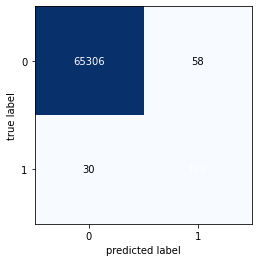

In [ ]:
matrix(confussionSEUNET)

In [ ]:
orderValDiceSEUnet,valDiceSEUnet = meanDicePerResults(results,Y_test)

In [ ]:
print("mean jaccard SE unet",np.mean(vSEUNet))
print("mean dice SE unet",np.mean(valDiceSEUnet))

mean jaccard SE unet 0.5347749681269212
mean dice SE unet 0.6839125223216301


In [ ]:
def get_one_image(imageNumber,jaccardValue,results):
  fig = plt.figure(figsize=(9, 4))
  ax = fig.add_subplot(1, 3, 1)
  Y_toPlot = results[imageNumber]
  img2 = np.zeros((Y_toPlot.shape[0],Y_toPlot.shape[1])+(3,))
  data = np.rollaxis(Y_toPlot, -1, 0)
  img2[:,:,0] = data[0]
  img2[:,:,1] = data[0]
  img2[:,:,2] = data[0]
  ax.imshow(img2, cmap=plt.cm.Greys_r)
  ax.set_title('Dice val ' + str(round(jaccardValue,2)))
  ax = fig.add_subplot(1, 3, 2)
  Y_toPlot = Y_test[imageNumber]
  img2 = np.zeros((Y_toPlot.shape[0],Y_toPlot.shape[1])+(3,))
  data = np.rollaxis(Y_toPlot, -1, 0)
  img2[:,:,0] = data[0]
  img2[:,:,1] = data[0]
  img2[:,:,2] = data[0]
  ax.imshow(img2, cmap=plt.cm.Greys_r)
  ax.set_title('Correct')
  ax = fig.add_subplot(1, 3, 3)
  ax.imshow(X_test[i])
  ax.set_title('Image')
  plt.show()

In [ ]:
print(orderValDiceSEUnet)

[24 31 29 17  1  7 40 28  6 15 18  5  4  2  0 33 27 26 23  8 19  3 13 16
 14 36 25 10 22 20 30 41 35 38 37 12 32 11  9 21 34 39]


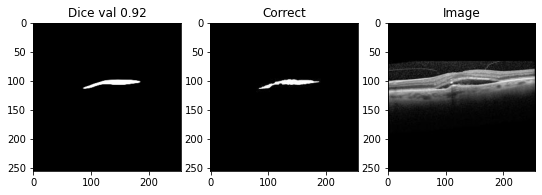

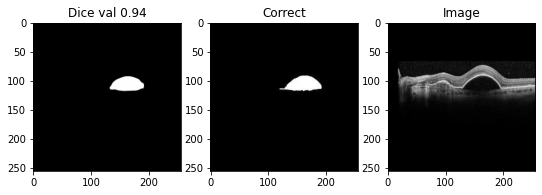

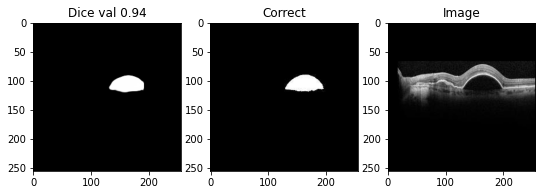

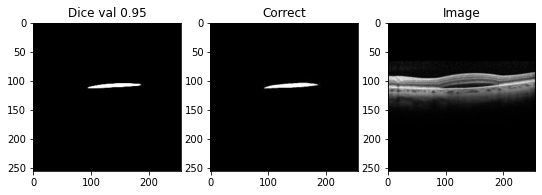

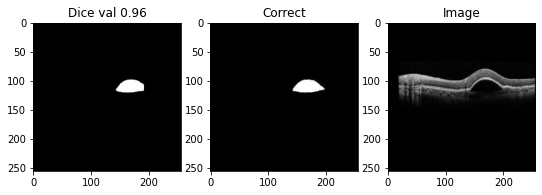

In [ ]:
BestFiveCases = orderValDiceSEUnet[-28:-23]
for i in BestFiveCases:
  get_one_image(i,valDiceSEUnet[i],results)

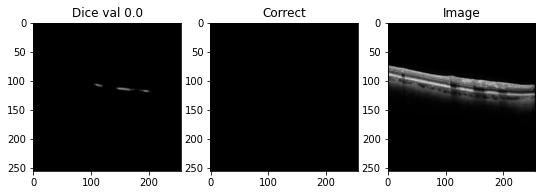

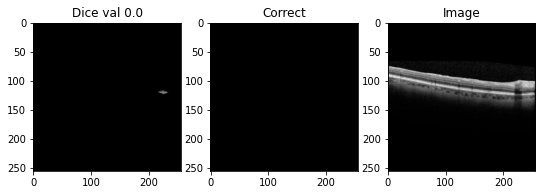

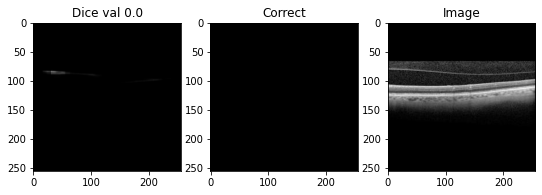

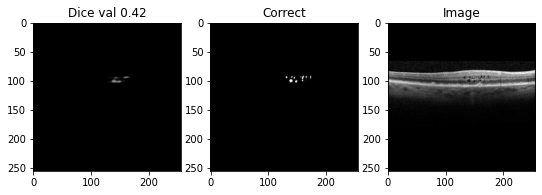

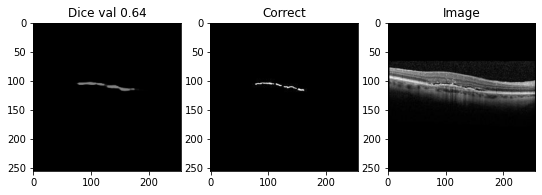

In [ ]:
WortsFiveCases = orderValDiceSEUnet[:5]
for i in WortsFiveCases:
  get_one_image(i,valDiceSEUnet[i],results)

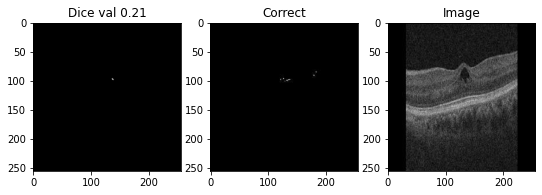

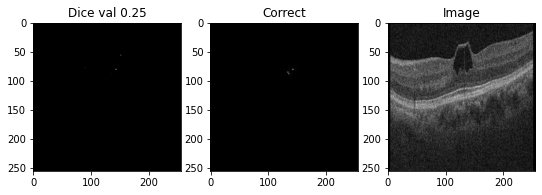

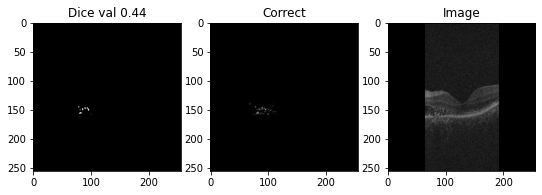

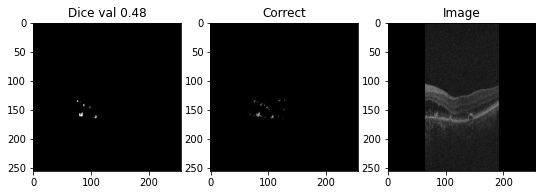

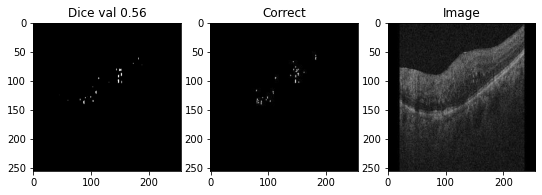

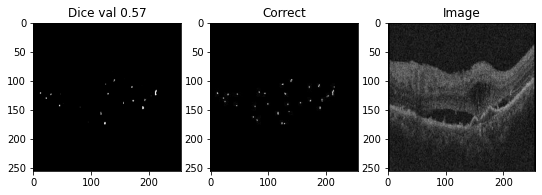

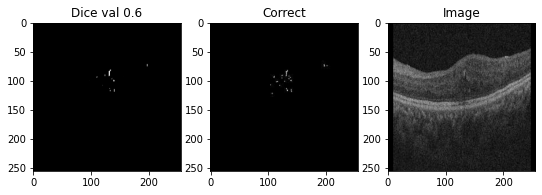

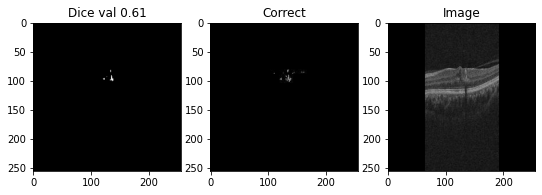

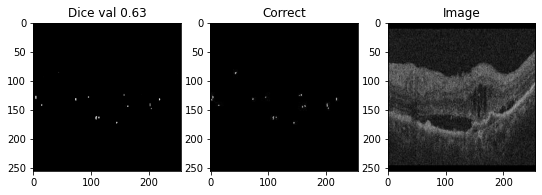

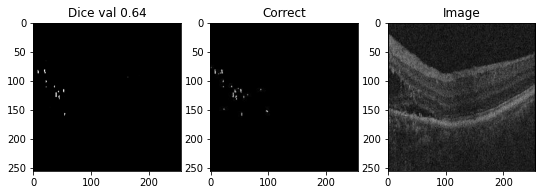

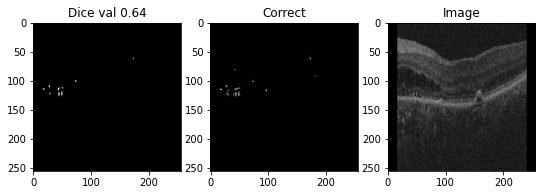

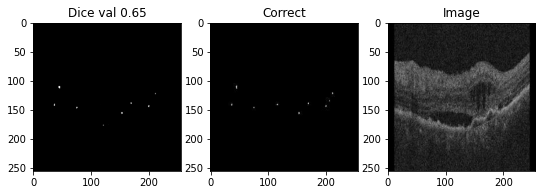

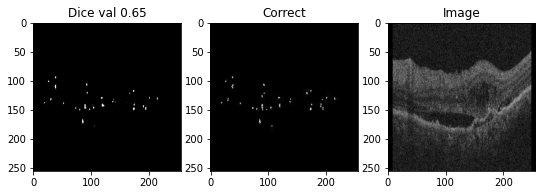

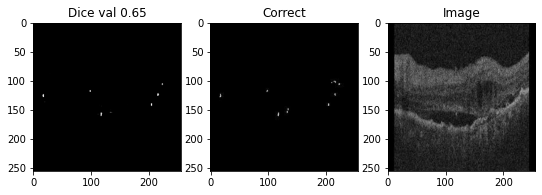

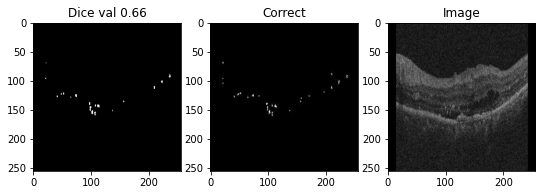

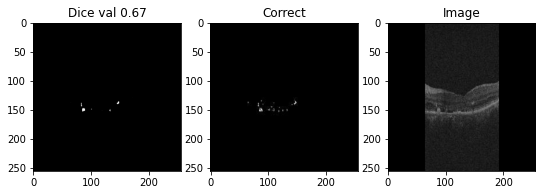

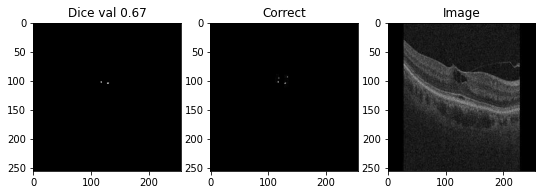

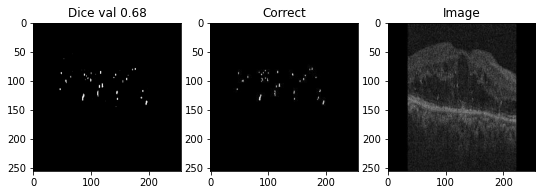

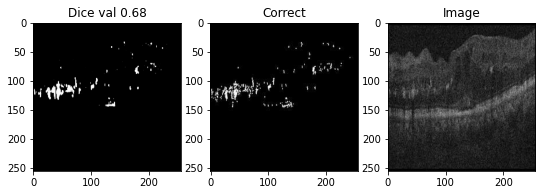

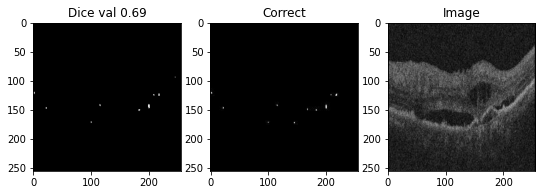

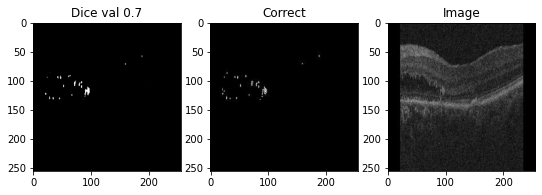

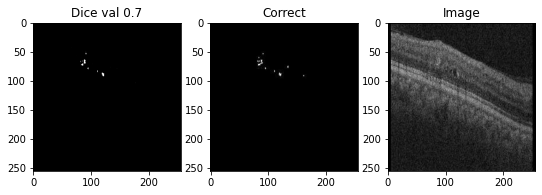

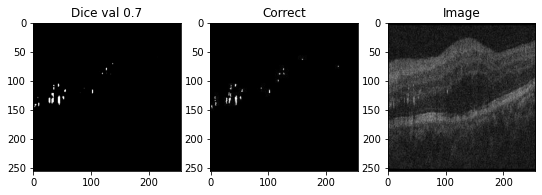

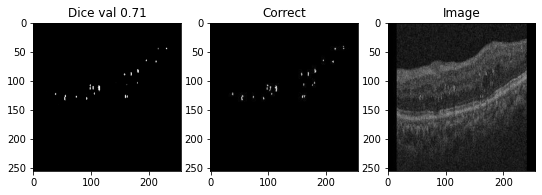

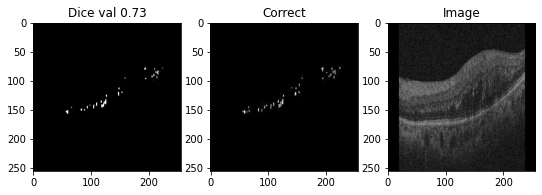

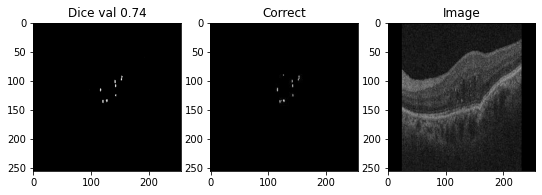

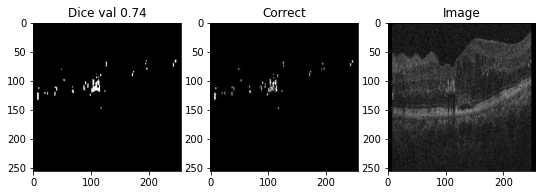

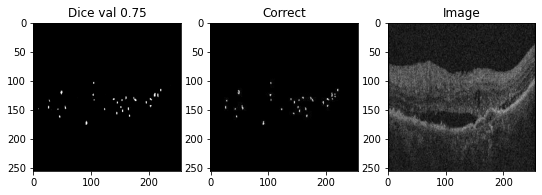

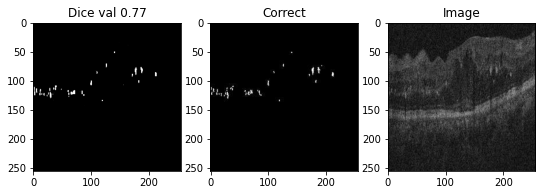

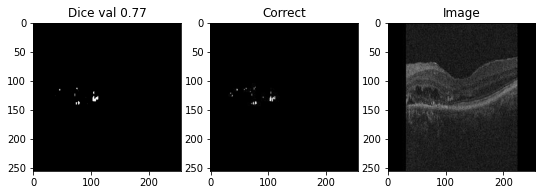

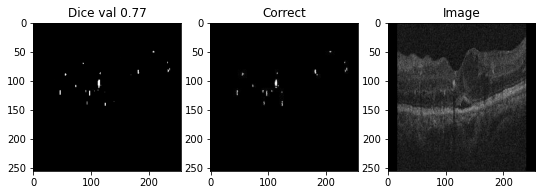

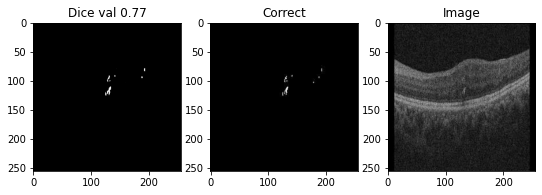

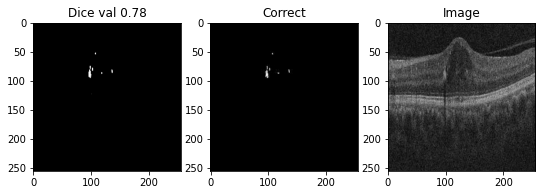

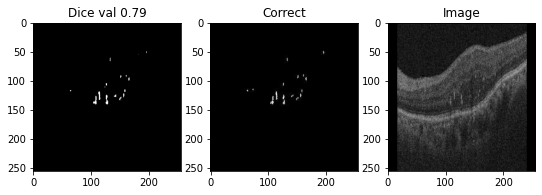

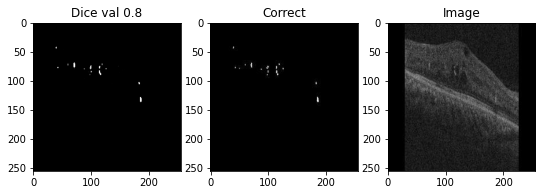

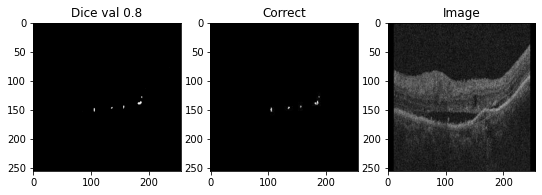

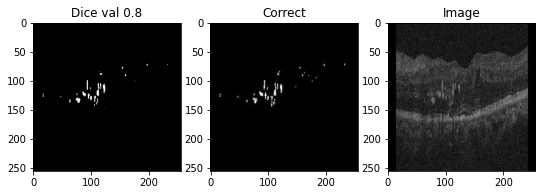

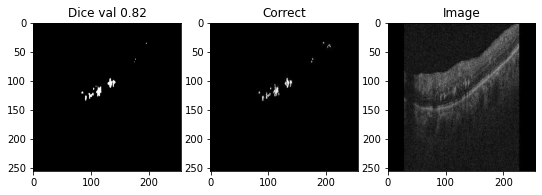

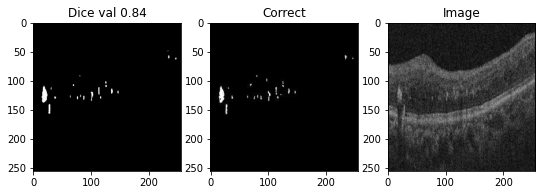

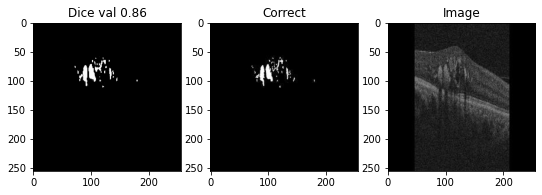

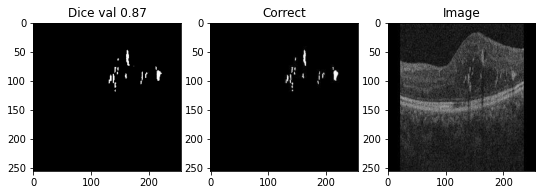

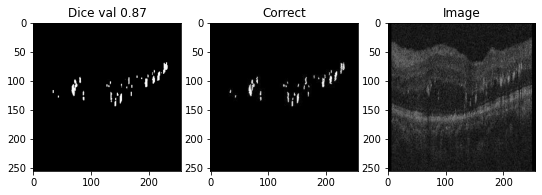

In [ ]:
for i in orderValDiceSEUnet:
  get_one_image(i,valDiceSEUnet[i],results)

In [ ]:
validationgenerator=generate_generator_multiple(validation_datagen,
                                          dir1=validation_data_dir,
                                          dir2=validation_mask_data_dir,
                                          batch_size=108,
                                          img_height=256,
                                          img_width=256)

In [ ]:
X_val, Y_val = next(validationgenerator)
print(X_val.shape,Y_val.shape)

Found 108 images belonging to 1 classes.
Found 108 images belonging to 1 classes.
(108, 256, 256, 3) (108, 256, 256, 1)


In [ ]:
resultsVal_SEunet = modelunet.predict(X_val)

In [ ]:
orderValDicevalSEUnet,valDicevalSEUnet = meanDicePerResults(resultsVal_SEunet,Y_val)

In [ ]:
print("mean validation dice se unet",np.mean(valDicevalSEUnet))

mean validation dice se unet 0.6111111111111112


In [ ]:
def get_one_image(imageNumber,jaccardValue,results):
  fig = plt.figure(figsize=(9, 4))
  ax = fig.add_subplot(1, 3, 1)
  Y_toPlot = results[imageNumber]
  img2 = np.zeros((Y_toPlot.shape[0],Y_toPlot.shape[1])+(3,))
  data = np.rollaxis(Y_toPlot, -1, 0)
  img2[:,:,0] = data[0]
  img2[:,:,1] = data[0]
  img2[:,:,2] = data[0]
  ax.imshow(img2, cmap=plt.cm.Greys_r)
  ax.set_title('Dice val ' + str(round(jaccardValue,2)))
  ax = fig.add_subplot(1, 3, 2)
  Y_toPlot = Y_val[imageNumber]
  img2 = np.zeros((Y_toPlot.shape[0],Y_toPlot.shape[1])+(3,))
  data = np.rollaxis(Y_toPlot, -1, 0)
  img2[:,:,0] = data[0]
  img2[:,:,1] = data[0]
  img2[:,:,2] = data[0]
  ax.imshow(img2, cmap=plt.cm.Greys_r)
  ax.set_title('Correct')
  ax = fig.add_subplot(1, 3, 3)
  ax.imshow(X_test[i])
  ax.set_title('Image')
  plt.show()

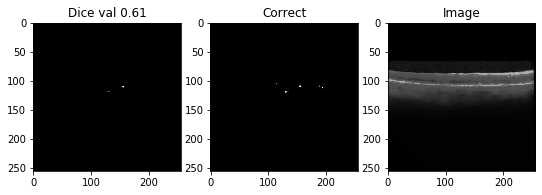

IndexError: ignored

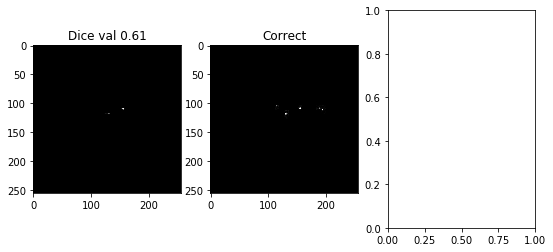

In [ ]:
for i in orderValDicevalSEUnet:
  get_one_image(i,valDicevalSEUnet[i],resultsVal_SEunet)